# Univariate Forecasting for NON OIL GDP Growth

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [5]:
file_path = "nonoilgdp_2024.csv"
data = pd.read_csv(file_path)

# Convert 'Years' to datetime
data['Years'] = pd.to_datetime(data['Years'], format='%Y')

# Set 'Years' as index
data.set_index('Years', inplace=True)

# Ensure the index is sorted
data.sort_index(inplace=True)

# Check the data
print("Columns in the dataset:", data.columns)
data.head()

Columns in the dataset: Index(['Non-Oil GDP Growth'], dtype='object')


,Non-Oil GDP Growth
Years,
1974-01-01,38.7
1975-01-01,26.6
1976-01-01,4.2
1977-01-01,4.4
1978-01-01,9.7


## Step 3: Viualizing Data

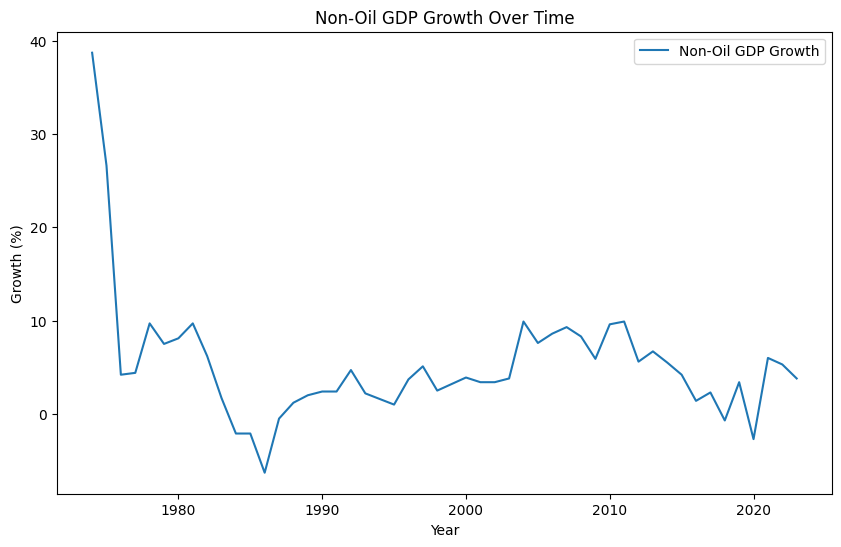

In [6]:
plt.figure(figsize=(10,6))
plt.plot(data['Non-Oil GDP Growth'], label='Non-Oil GDP Growth')
plt.title('Non-Oil GDP Growth Over Time')
plt.xlabel('Year')
plt.ylabel('Growth (%)')
plt.legend()
plt.show()

## Step 4: Check for Stationarity

In [7]:
# Perform Dickey-Fuller Test
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(data['Non-Oil GDP Growth'])

Results of Dickey-Fuller Test:
Test Statistic                -6.470910e+00
p-value                        1.367937e-08
#Lags Used                     1.000000e+00
Number of Observations Used    4.800000e+01
Critical Value (1%)           -3.574589e+00
Critical Value (5%)           -2.923954e+00
Critical Value (10%)          -2.600039e+00
dtype: float64


 ## Step 5: Decompose the Time Series (if seasonal)

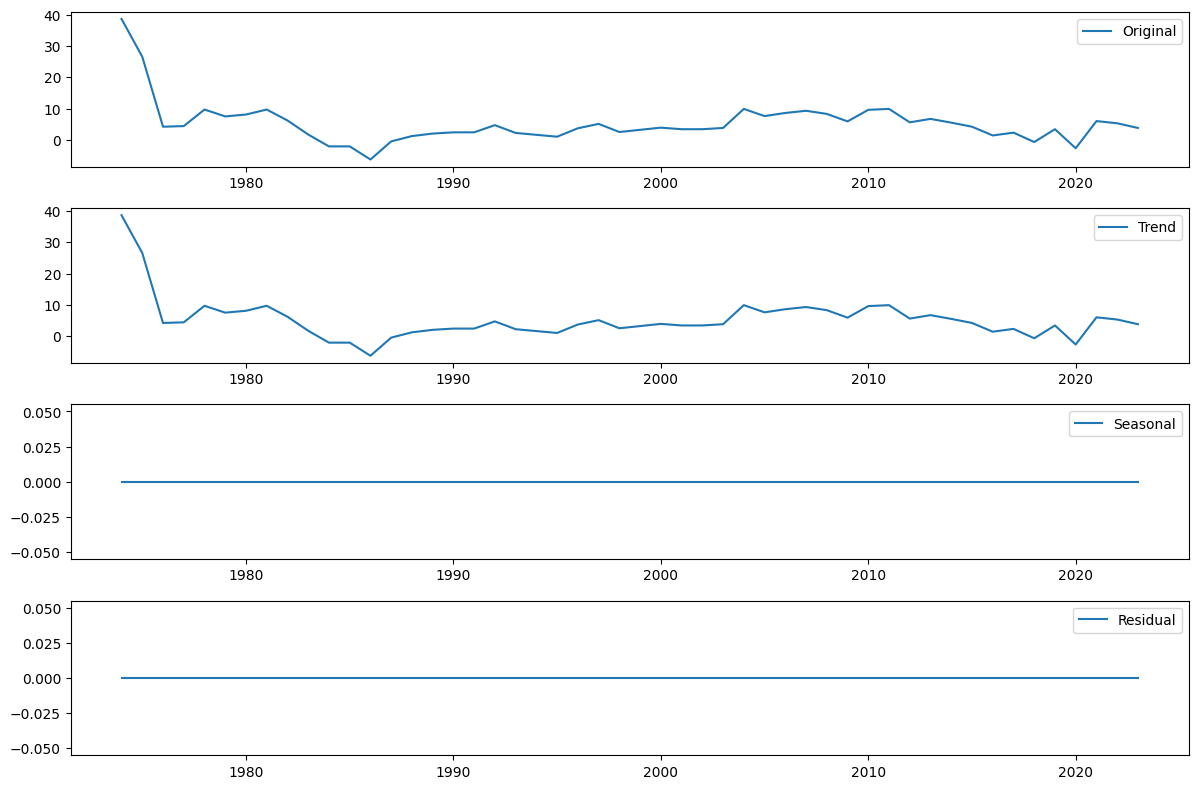

In [8]:
# Decompose the time series
decomposition = seasonal_decompose(data['Non-Oil GDP Growth'], model='additive', period=1)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(data['Non-Oil GDP Growth'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Step 6: Fit an SARIMA Model

In [11]:
import itertools


In [12]:
# Split the data into train and test sets
train = data.loc[data.index < '2020-01-01']
test = data.loc[data.index >= '2020-01-01']

# Grid search for best SARIMA parameters
p = d = q = range(0,2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

best_aic = np.inf
best_order = None
best_seasonal_order = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(train['Non-Oil GDP Growth'],
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            results = mod.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = param_seasonal
        except:
            continue

print('Best SARIMA{}x{} model - AIC:{}'.format(best_order, best_seasonal_order, best_aic))

Best SARIMA(0, 1, 1)x(1, 1, 1, 12) model - AIC:102.1522701170519


## Step 7: Fit the model with Best Parameters

In [13]:
# Fit the SARIMA model with best parameters
mod = SARIMAX(train['Non-Oil GDP Growth'],
              order=best_order,
              seasonal_order=best_seasonal_order,
              enforce_stationarity=False,
              enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                 Non-Oil GDP Growth   No. Observations:                   46
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -47.076
Date:                            Tue, 07 Jan 2025   AIC                            102.152
Time:                                    14:01:48   BIC                            105.930
Sample:                                01-01-1974   HQIC                           102.792
                                     - 01-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3240      0.214     -1.511      0.131      -0.744       0.096
ar.S.L12      -0.3897      0.273   

## Step 8: Make Predictions

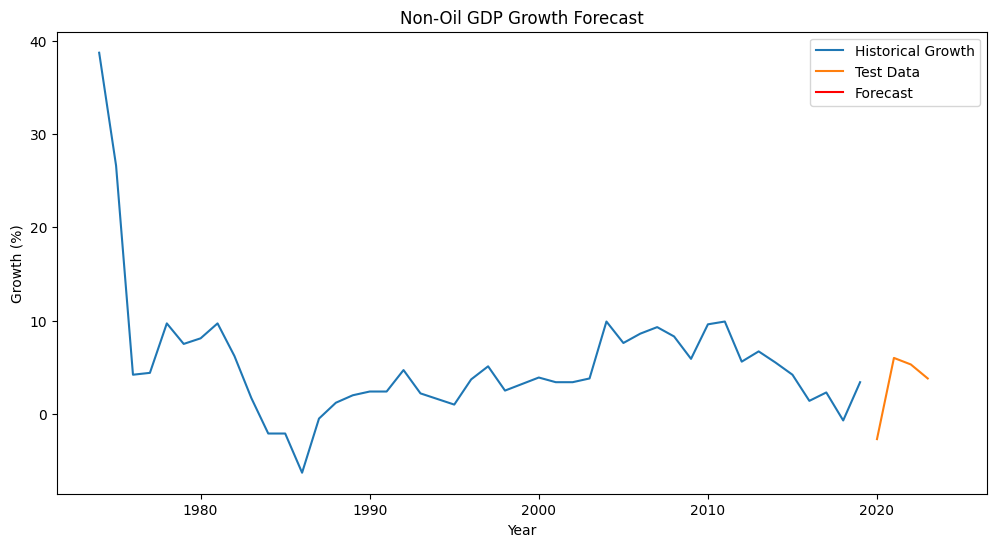

In [26]:
# Forecast the next 5 years
pred_dynamic = results.forecast(steps=5)
index_future = pd.date_range(start='2024-01-01', periods=5, freq='YS')
pred_dynamic = pd.Series(pred_dynamic, index=index_future)

# Combine historical data and predictions for plotting
combined = pd.concat([data['Non-Oil GDP Growth'], pred_dynamic], axis=0)

# Plot the results
plt.figure(figsize=(12,6))
plt.plot(train['Non-Oil GDP Growth'], label='Historical Growth')
plt.plot(test['Non-Oil GDP Growth'], label='Test Data')
plt.plot(pred_dynamic, label='Forecast', color='red')
plt.title('Non-Oil GDP Growth Forecast')
plt.xlabel('Year')
plt.ylabel('Growth (%)')
plt.legend()
plt.show()

## Step 9: Evaluate the Model

In [27]:
print((test['Non-Oil GDP Growth']), (pred_dynamic))


Years
2020-01-01   -2.7
2021-01-01    6.0
2022-01-01    5.3
2023-01-01    3.8
Name: Non-Oil GDP Growth, dtype: float64 2024-01-01    1.504284
2025-01-01         NaN
2026-01-01         NaN
2027-01-01         NaN
2028-01-01         NaN
Freq: YS-JAN, Name: predicted_mean, dtype: float64


In [23]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Non-Oil GDP Growth'], pred_dynamic))
print('Root Mean Squared Error:', rmse)

# Compare with IMF projections
imf_projections = [5.3, 3.8, 3.4, 4.4]
forecast_values = pred_dynamic.tolist()
print('Forecasted Values:', forecast_values)
print('IMF Projections:', imf_projections)

ValueError: Input contains NaN.